# Integrating scCAT-seq cell lines

## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Maths
import pandas as pd
import numpy as np
import torch
from torch import optim
from umap import UMAP

In [3]:
# Our packages
from mowgli import models, pl, tl, utils

In [4]:
# Plotting
import matplotlib.pyplot as plt

## Load data

Load the Liu cell lines dataset, which contains 3 well separated cell lines profiled with scRNA-seq and scATAC-seq.

In [5]:
mdata = mu.read_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz')
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Selecting highly variable features

For computational reasons, in this simple demonstration we reduce the number of features a lot.

In [63]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=500)

# Highly variable peaks
sc.pp.highly_variable_genes(atac, min_mean=1e-5, max_mean=4, min_disp=1, n_top_genes=500)

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

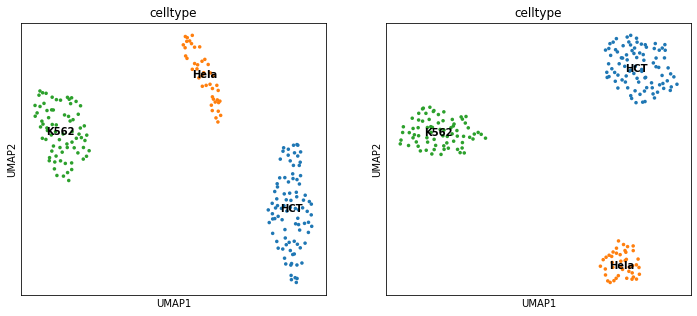

In [64]:
# Umap RNA
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)

# Umap ATAC
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)

# Display UMAP
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50, show=False, ax=axes[0])
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50, show=False, ax=axes[1])
plt.show()

## Perform NMF

Let us define the model and perform the dimensionaly reduction.

In [122]:
# Define the model.
nmf = models.MowgliModel(
    latent_dim=3,
    rho_h=1e-2,
    rho_w=1e-3,
    eps=.1,
    cost='cosine')

In [123]:
# Perform the training.
nmf.train(mdata)

  4%|▍         | 8/200 [00:30<12:09,  3.80s/it, loss=0.19658983, mass_transported=0.381, loss_inner=-0.20209597, inner_steps=120, gpu_memory_allocated=0]


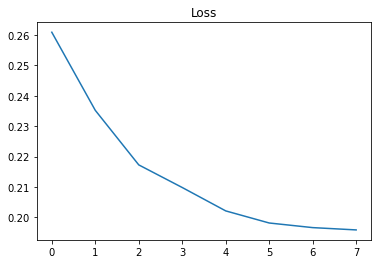

In [124]:
# Display the training loss.
plt.title('Loss')
plt.plot(nmf.losses)
plt.show()

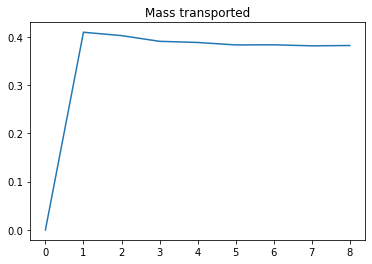

In [125]:
# Display the training loss.
plt.title('Mass transported')
plt.plot(nmf.scores_history)
plt.show()

In [126]:
for mod in nmf.mod:
    print(mod, utils.entropy(nmf.H[mod])/(nmf.latent_dim*np.log(nmf.n_var[mod])))

atac tensor(0.9559)
rna tensor(0.9293)


In [127]:
for mod in nmf.mod:
    print(mod, utils.entropy(nmf.W)/(nmf.n_obs*np.log(nmf.latent_dim)))

atac tensor(0.6132)
rna tensor(0.6132)


## Visualize the embedding

Now, let us display the obtained embedding.

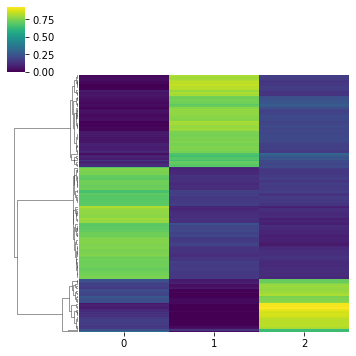

In [128]:
# First, using a dendogram.
pl.clustermap(mdata, 'W_OT', yticklabels=False, figsize=(5, 5), col_cluster=False)

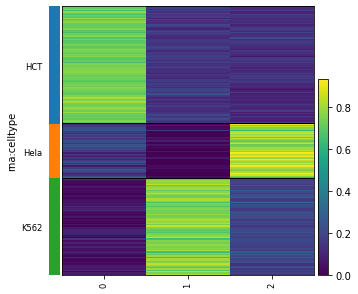

In [129]:
# Then, using the ground truth clusters.
pl.heatmap(mdata, 'W_OT', 'rna:celltype', figsize=(5, 5))

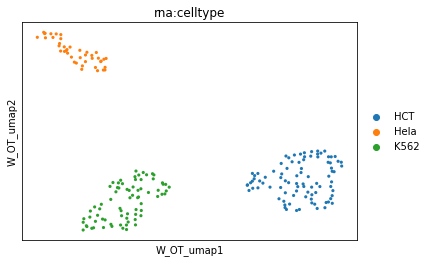

In [130]:
# Finally, we can compute an UMAP embedding and display it.
tl.umap(mdata, 'W_OT', metric='l1', min_dist=.6, spread=1)
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

We can zoom in on a particular factor to interpret it biologically.

In [131]:
# Display the 3 highest contributors to dimension 0, for ATAC-seq.
tl.top_features(mdata, 'atac', 'H_OT', dim=1, n_features=3)

['K562_peak_36376h', 'K562_peak_42147', 'K562_peak_23287']

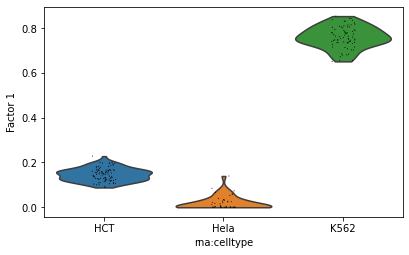

In [132]:
# Display a violoin plot of the value at dimension 0 of the cells.
pl.factor_violin(mdata, groupby='rna:celltype', dim=1)

## Clustering

We can perform clustering on the lower-dimensional space.

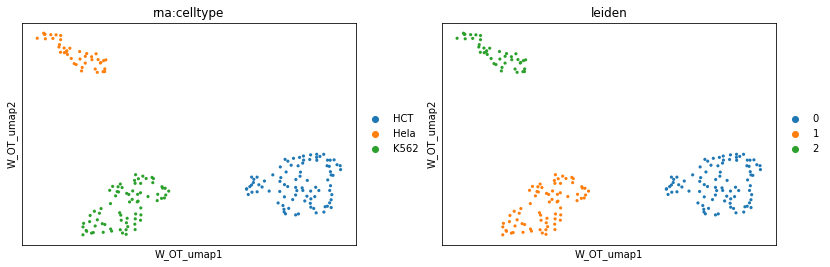

In [133]:
tl.leiden(mdata, resolution=.1)
mu.pl.embedding(mdata, 'W_OT_umap', ['rna:celltype', 'leiden'], size=40)